In [116]:
from os.path import abspath, join
import pandas as pd
import numpy as np
from plotnine import ggplot, geom_bar, aes, scale_x_discrete, theme, element_text, labs, \
    geom_histogram, facet_wrap, element_blank, scale_x_continuous, scale_y_continuous, geom_line, \
    geom_boxplot, coord_flip, scale_y_discrete, ylim

In [117]:
# SETUP DATA
path = "C:/Users/t-niamit/JavaAnalyzer"
results_file = "analyzerResults_v2.csv"
df = pd.read_csv(abspath(join(path, results_file)))

df = df[~df["className"].isin(["TypeParameter","ClassOrInterfaceType"])]

all_frequencies = pd.read_csv(abspath(join(path, 'analyzerResults_words_ALL.csv')))
filtered_out_words = all_frequencies[np.where(all_frequencies['external'] == 1, True, False)][
	'word']
df["external"] = df['name'].isin(filtered_out_words)


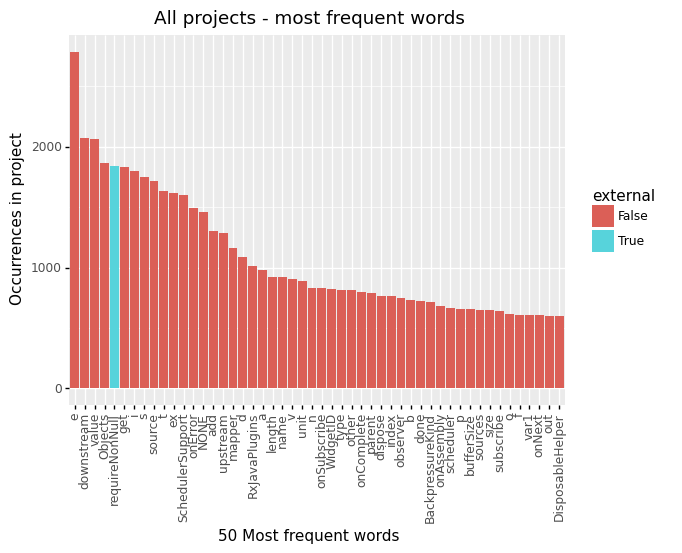

In [118]:
n=50
hist_name_external_all = df.groupby(["name", "external"]).size().reset_index(name="count")
hist_name_external_all = hist_name_external_all.nlargest(n, "count")

print(
	ggplot(hist_name_external_all)
	+ labs(x=str(n) + " Most frequent words",
		   y="Occurrences in project",
		   title="All projects - most frequent words")
	+ scale_x_discrete(limits=hist_name_external_all['name'].tolist())
	+ geom_bar(aes(x='name', y='count', fill="external"), stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

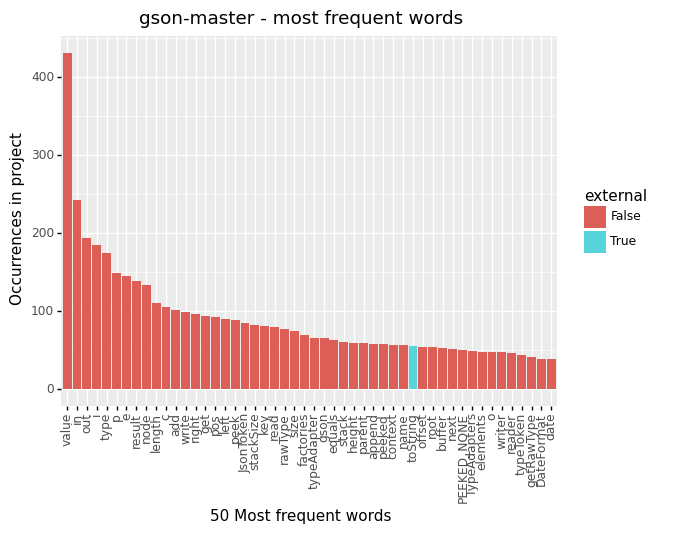

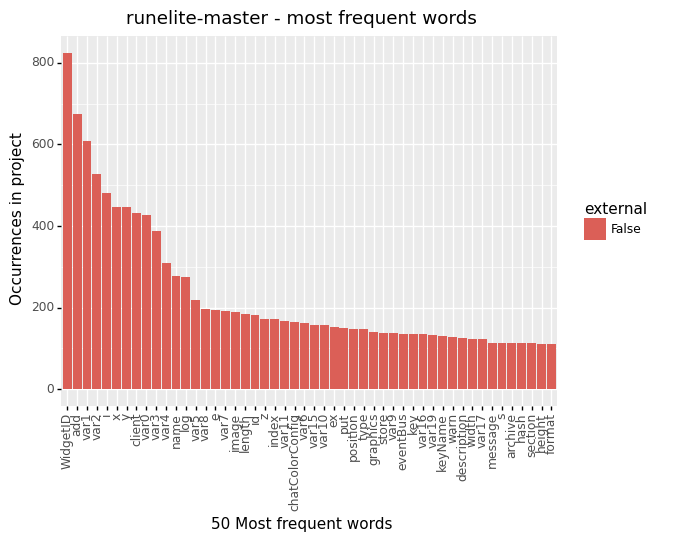

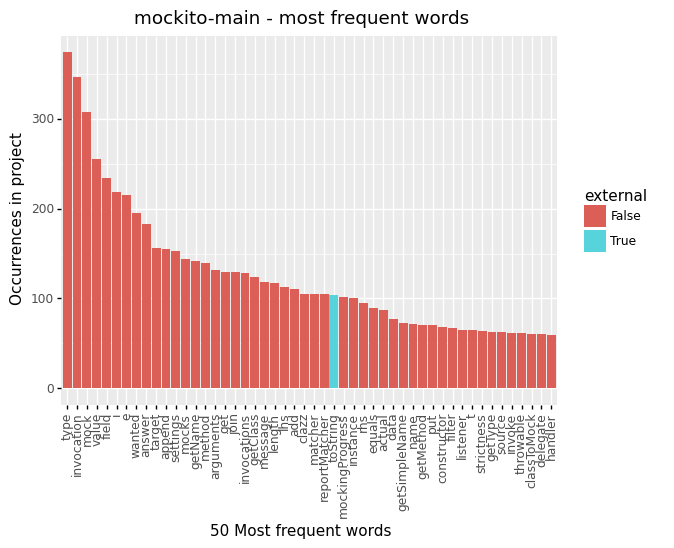

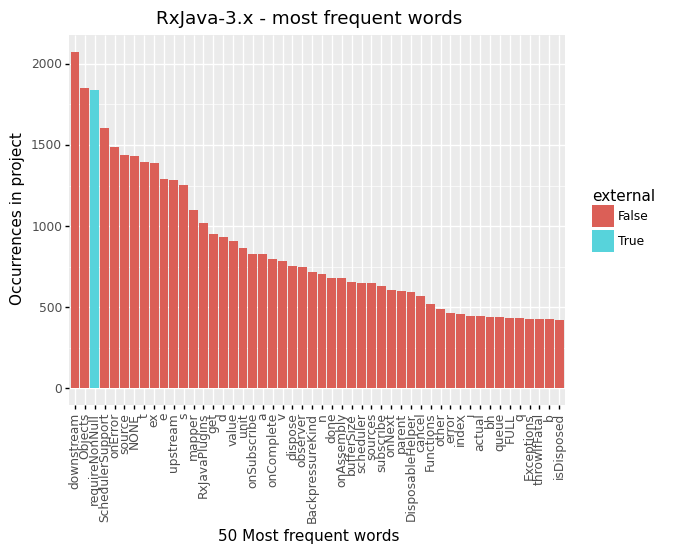

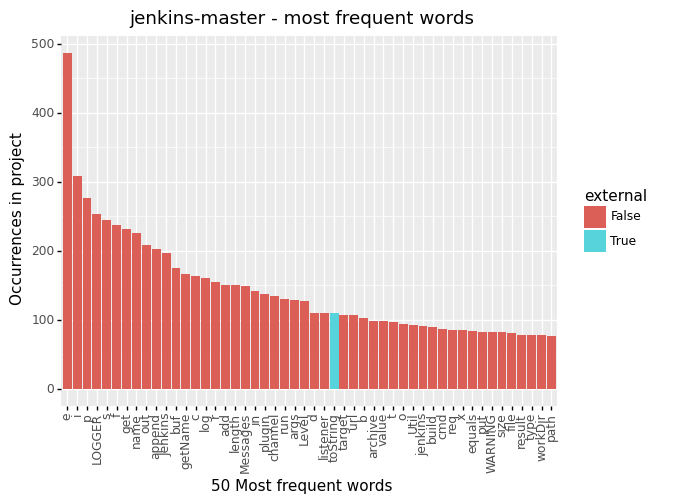

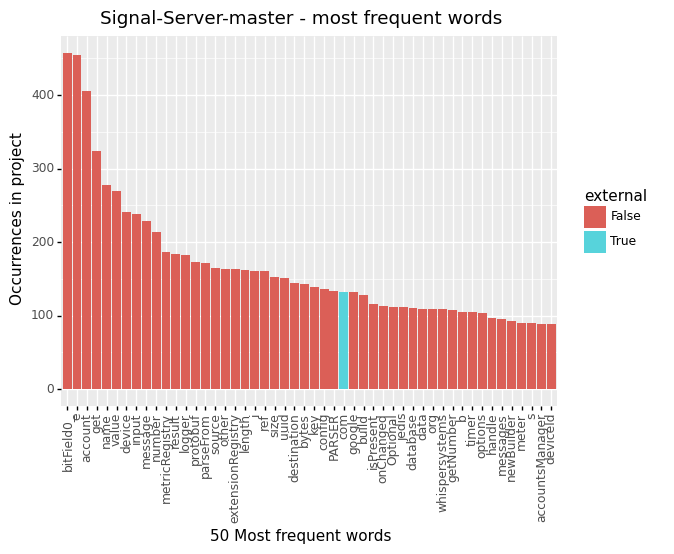

In [119]:
hist_name_project_external = df.groupby(["name", "project", "external"]).size().reset_index\
	(name="count")

for project_name in hist_name_project_external.project.unique():
	project = hist_name_project_external[hist_name_project_external["project"] == project_name]
	project = project.nlargest(n, "count")
	print(
		ggplot(project)
		+ labs(x=str(n) + " Most frequent words",
			   y="Occurrences in project",
			   title=project_name + " - most frequent words")
		+ scale_x_discrete(limits=project['name'].tolist())
		+ geom_bar(aes(x='name', y='count', fill="external"), stat='identity')
		+ theme(axis_text_x=element_text(rotation=90))
	)


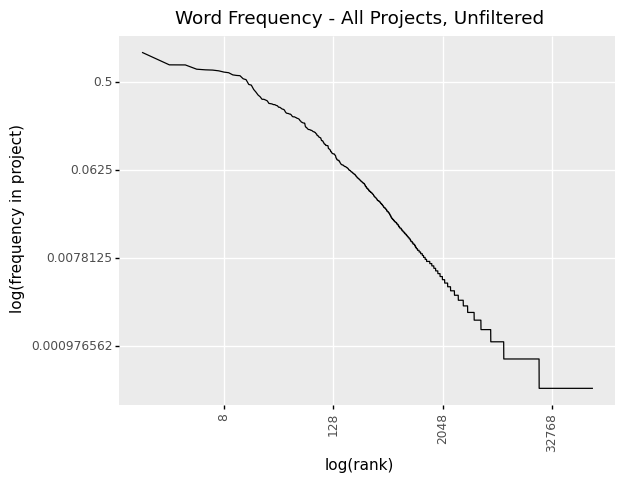

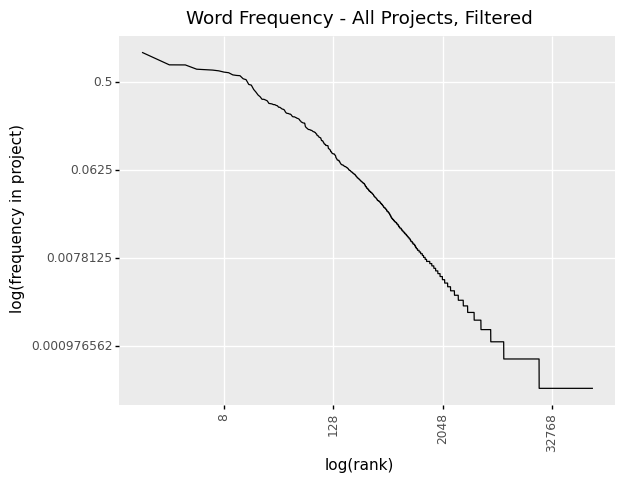

In [120]:
freq_name_external_all = df.groupby(["name", "external"]).size() \
	.reset_index(name="count") \
	.sort_values("count", ascending=False)
most_frequent_word_occurrences = int(freq_name_external_all[:1]['count'])

freq_name_external_all['frequency'] = freq_name_external_all['count'] / most_frequent_word_occurrences
data_length = freq_name_external_all.shape[0]
freq_name_external_all['rank'] = np.linspace(1, data_length, data_length)

print(ggplot(freq_name_external_all)
	  + labs(x="log(rank)",
			 y="log(frequency in project)",
			 title="Word Frequency - All Projects, Unfiltered")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x='rank', y='frequency'), stat='identity')
	  + theme(axis_text_x=element_text(rotation=90))
	  )

print(ggplot(freq_name_external_all[freq_name_external_all["external"] == False])
	  + labs(x="log(rank)",
			 y="log(frequency in project)",
			 title="Word Frequency - All Projects, Filtered")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x='rank', y='frequency'), stat='identity')
	  + theme(axis_text_x=element_text(rotation=90))
	  )



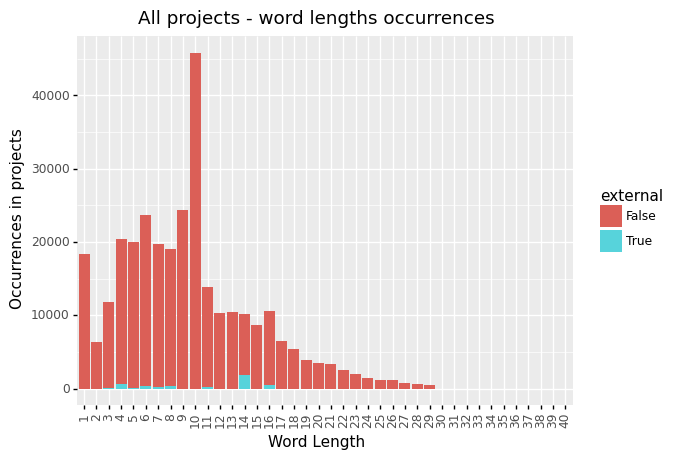

In [121]:
freq_length_external_all = df.groupby(["length", "project", "external"])\
	.size() \
	.reset_index(name="count") \
	.sort_values("count", ascending=False)
most_frequent_length_occurrences = int(freq_length_external_all[:1]['count'])

freq_length_external_all['frequency'] = \
	freq_length_external_all['count'] / most_frequent_length_occurrences
data_length = freq_length_external_all.shape[0]
freq_length_external_all['rank'] = np.linspace(1, data_length, data_length)


n=40
hist_length_external_all = df.groupby(["length", "external"]).size().reset_index(name="count")
hist_length_external_all = hist_length_external_all.nsmallest(n, "length")

print(
	ggplot(hist_length_external_all)
	+ labs(x="Word Length",
		   y="Occurrences in projects",
		   title="All projects - word lengths occurrences")
	+ scale_x_discrete(limits=range(1, 41))
	+ geom_bar(aes(x='length', y='count', fill="external"), stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

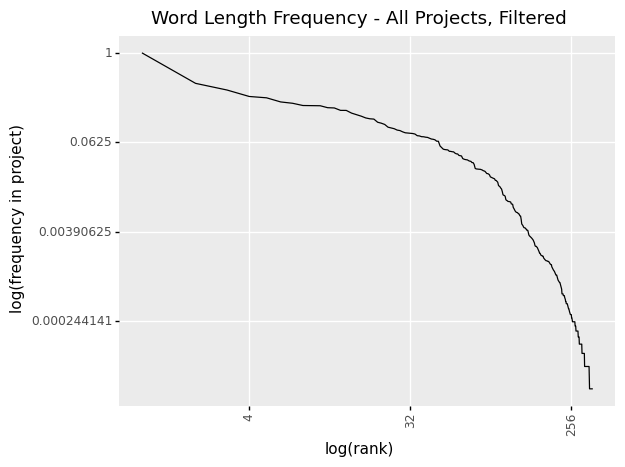

In [122]:
print(ggplot(freq_length_external_all[freq_length_external_all["external"] == False])
      + labs(x="log(rank)",
             y="log(frequency in project)",
             title="Word Length Frequency - All Projects, Filtered")
      + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
      + geom_line(aes(x='rank', y='frequency'), stat='identity')
      + theme(axis_text_x=element_text(rotation=90))
      )

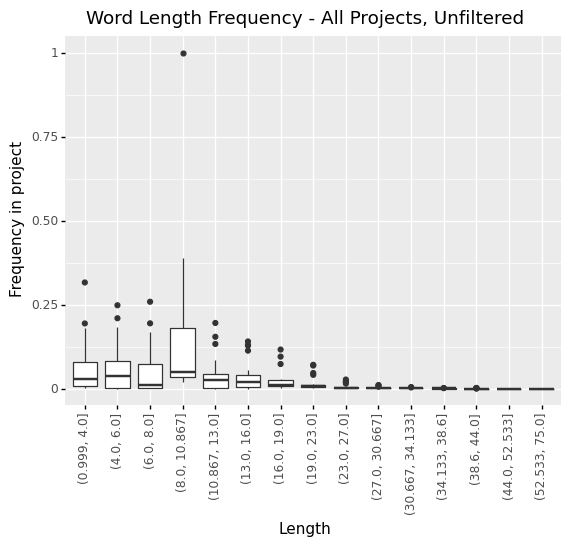

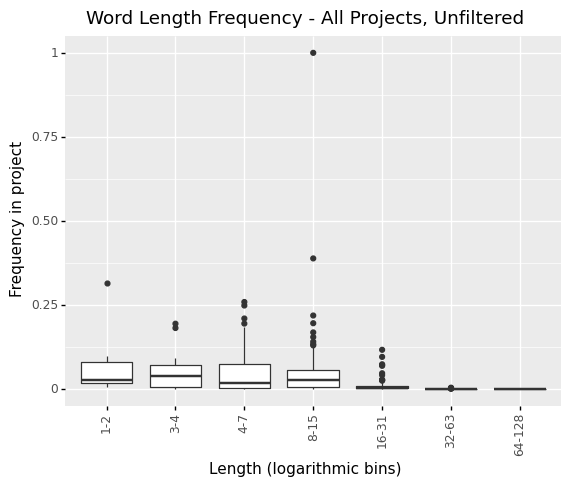

In [123]:
bins = 15
freq_length_external_all["bin"] = pd.qcut(freq_length_external_all["length"], q=bins)
freq_length_external_all["freq_bin"] = pd.cut(freq_length_external_all["frequency"],
                                               bins=np.array([0, 1, 2, 4, 8, 16, 32, 64, 128])/128)

freq_length_external_all["log_bin"] = pd.cut(freq_length_external_all["length"],
											 bins=([0] + list(np.logspace(1, 7, 7, base=2))),
											 labels=["1-2", "3-4","4-7","8-15","16-31","32-63",
													 "64-128"])

print(ggplot(freq_length_external_all)
			+ labs(x="Length",
				   y="Frequency in project",
				   title="Word Length Frequency - All Projects, Unfiltered")
	  + geom_boxplot(aes(x='bin', y='frequency'))
      + theme(axis_text_x=element_text(rotation=90))
      )

print(ggplot(freq_length_external_all)
	  + labs(x="Length (logarithmic bins)",
			 y="Frequency in project",
			 title="Word Length Frequency - All Projects, Unfiltered")
	  # + scale_y_continuous(trans='log2')
	  + geom_boxplot(aes(x='log_bin', y='frequency'))
      + theme(axis_text_x=element_text(rotation=90))
	  )


c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 1066 rows containing non-finite values.


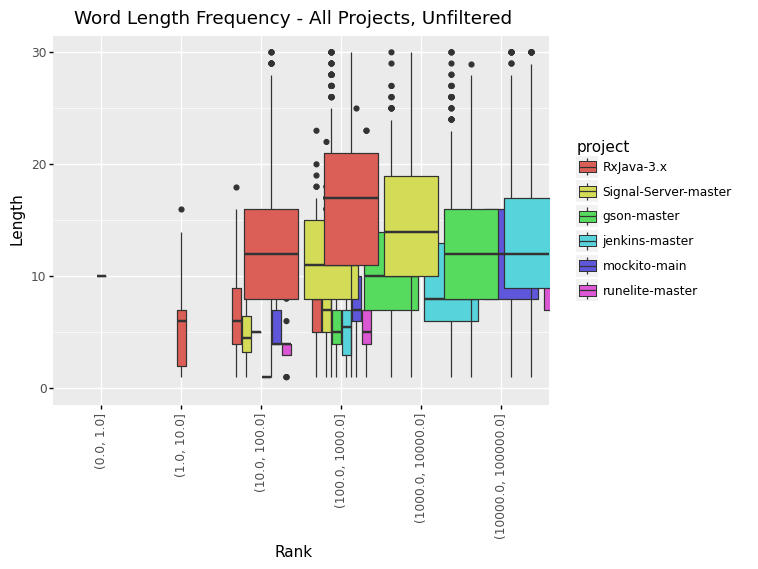

c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 1066 rows containing non-finite values.


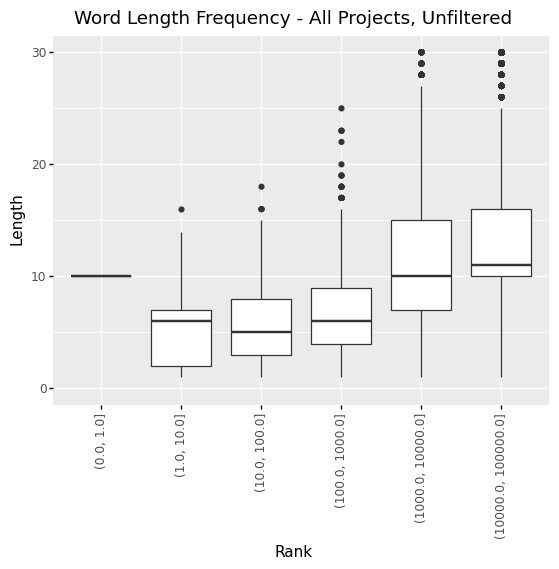

In [124]:
freq_name_length_project = df.groupby(["name", "length", "project"]).size() \
    .reset_index(name="count") \
    .sort_values("count", ascending=False)
most_frequent_length_occurrences = int(freq_name_length_project[:1]['count'])
data_length = freq_name_length_project.shape[0]
freq_name_length_project['rank'] = np.linspace(1, data_length, data_length)

target_bin = int(np.round(np.math.log(freq_name_length_project.shape[0])))
freq_name_length_project["rank_bin"] = pd.cut(freq_name_length_project["rank"], bins=[0]+list(np.logspace(0, target_bin, target_bin+1)))

c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 1066 rows containing non-finite values.


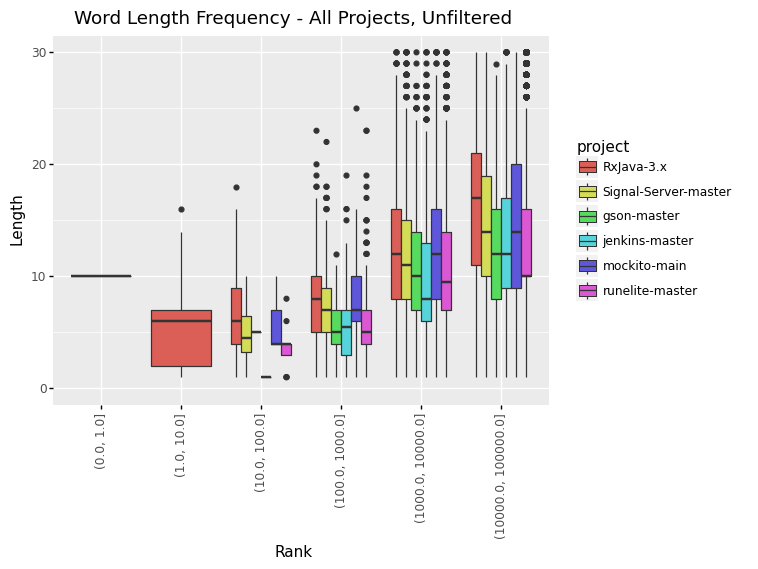

c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 1066 rows containing non-finite values.


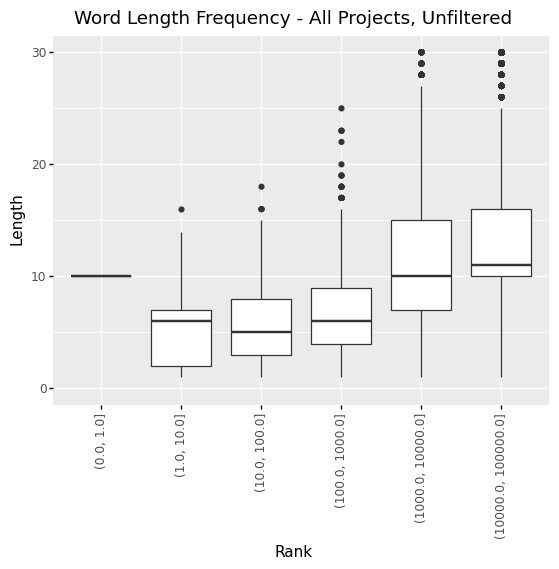

In [132]:
print(ggplot(freq_name_length_project)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='rank_bin', y='length', fill="project"), position="dodge")
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

print(ggplot(freq_name_length_project)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='rank_bin', y='length'))
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 1063 rows containing non-finite values.


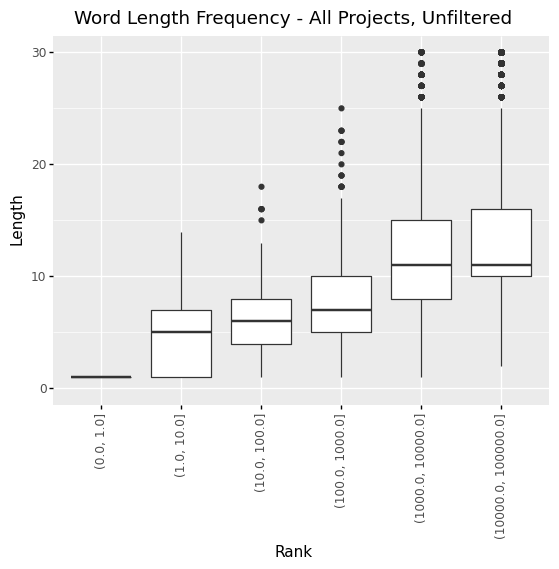

In [131]:
freq_name_length = df.groupby(["name", "length"]) \
    .size() \
    .reset_index(name="count") \
    .sort_values("count", ascending=False)
most_frequent_length_occurrences = int(freq_name_length[:1]['count'])
data_length = freq_name_length.shape[0]
freq_name_length['rank'] = np.linspace(1, data_length, data_length)

target_bin = int(np.round(np.math.log(freq_name_length.shape[0])))
freq_name_length["rank_bin"] = pd.cut(freq_name_length["rank"], bins=[0]+list(np.logspace(0, target_bin, target_bin+1)))
#
# freq_length['frequency'] = freq_length['count'] / most_frequent_length_occurrences
#
# freq_length["freq_bin"] = pd.cut(freq_length["frequency"],
#                                               bins=np.array([0, 1, 2, 4, 8, 16, 32]) / 32)

print(ggplot(freq_name_length)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='rank_bin', y='length'))
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

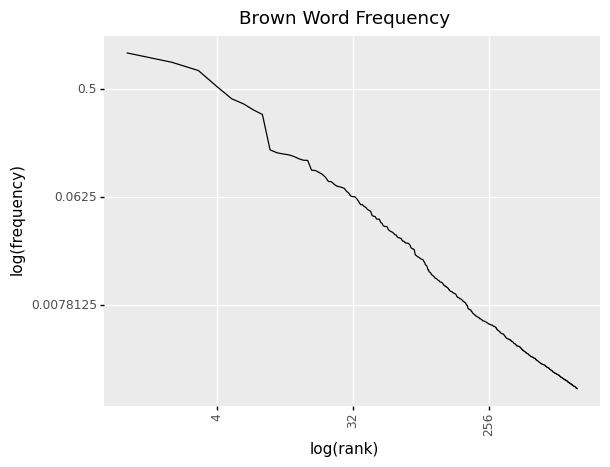

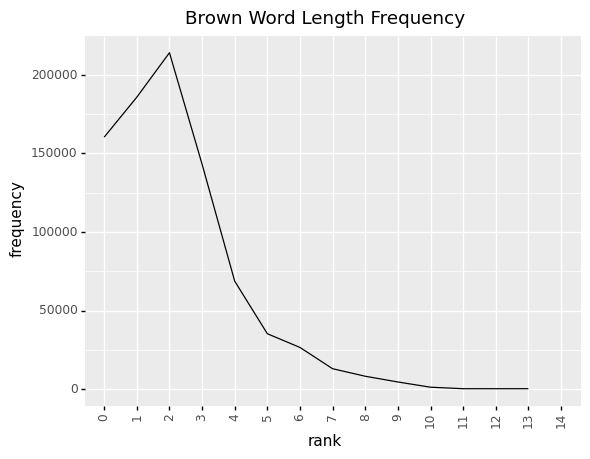

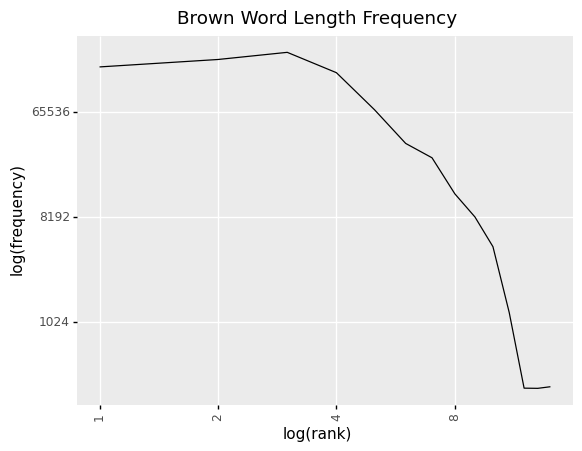

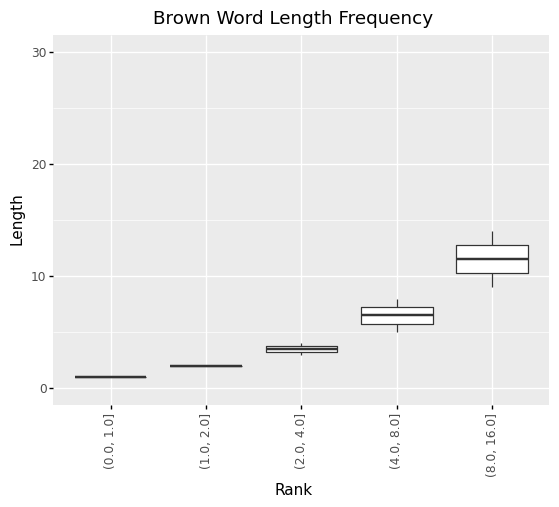

In [126]:
# Setup English data
results_file = "brown.csv"
brown_df = pd.read_csv(abspath(join(path, results_file)))

brown_word_freq = brown_df.groupby(["Item"]).Frequency.sum()\
	.reset_index()\
	.sort_values("Frequency", ascending=False)
brown_most_freq_word_occurrences = int(brown_word_freq[:1]['Frequency'])

brown_word_freq['Frequency'] = brown_word_freq['Frequency'] / brown_most_freq_word_occurrences
brown_data_length = brown_word_freq.shape[0]
brown_word_freq['rank'] = np.linspace(1, brown_data_length, brown_data_length)

print(ggplot(brown_word_freq)
	  + labs(x="log(rank)",
			 y="log(frequency)",
			 title="Brown Word Frequency")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x='rank', y='Frequency'), stat='identity')
	  + theme(axis_text_x=element_text(rotation=90))
	  )



brown_df["length"] = brown_df['Item'].str.len()
brown_length_freq = brown_df.groupby(["length"]).Frequency.sum().reset_index()
brown_data_length = brown_length_freq.shape[0]
brown_length_freq['rank'] = np.linspace(1, brown_data_length, brown_data_length)

brown_target_bin = int(np.round(np.math.log2(brown_length_freq.shape[0])))
brown_length_freq["rank_bin"] = pd.cut(brown_length_freq["rank"], bins=[0]+list(np.logspace(0, brown_target_bin, brown_target_bin+1, base=2)))


print(ggplot(brown_length_freq)
      + labs(x="rank",
             y="frequency",
             title="Brown Word Length Frequency")
	  + scale_x_discrete(limits=range(0, 15))
      # + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
      + geom_line(aes(x='rank', y='Frequency'), stat='identity')
      + theme(axis_text_x=element_text(rotation=90))
      )

print(ggplot(brown_length_freq)
      + labs(x="log(rank)",
             y="log(frequency)",
             title="Brown Word Length Frequency")
      + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
      + geom_line(aes(x='rank', y='Frequency'), stat='identity')
      + theme(axis_text_x=element_text(rotation=90))
      )

print(ggplot(brown_length_freq)
      + labs(y="Length",
             x="Rank",
             title="Brown Word Length Frequency")
      + geom_boxplot(aes(x='rank_bin', y='length'))
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

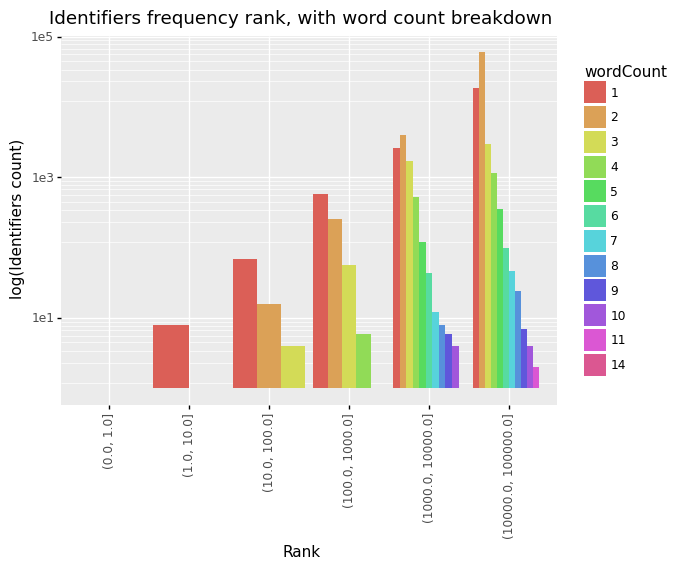

In [127]:
import re
from plotnine import scale_y_log10


def camel_case_split_and_count(inpt):
	if inpt is None:
		return 0
	return len(re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[_A-Z]*(?=[_A-Z]|$))', str(inpt)))


wordCount_freq = df.groupby("name").size().reset_index(name="count").sort_values("count", ascending=False)
wordCount_freq["wordCount"] = wordCount_freq["name"].apply(camel_case_split_and_count).astype('category')
most_frequent_word_occurrences = int(wordCount_freq[:1]['count'])
data_length = wordCount_freq.shape[0]
wordCount_freq['frequency'] = wordCount_freq['count'] / most_frequent_word_occurrences
wordCount_freq['rank'] = np.linspace(1, data_length, data_length)

target_bin = int(np.round(np.math.log(wordCount_freq.shape[0])))
wordCount_freq["rank_bin"] = pd.cut(wordCount_freq["rank"],
									bins=[0] + list(np.logspace(0, target_bin, target_bin + 1)))

print(
	ggplot(wordCount_freq)
	+ labs(x="Rank",
		   y="log(Identifiers count)",
		   title="Identifiers frequency rank, with word count breakdown")
	+ geom_bar(aes(x='rank_bin', fill="wordCount"), position="dodge")
	+ scale_y_continuous(trans='log10')
	+ theme(axis_text_x=element_text(rotation=90))
)

c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_count : Removed 416 rows containing non-finite values.
c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_bar : Removed 8 rows containing missing values.


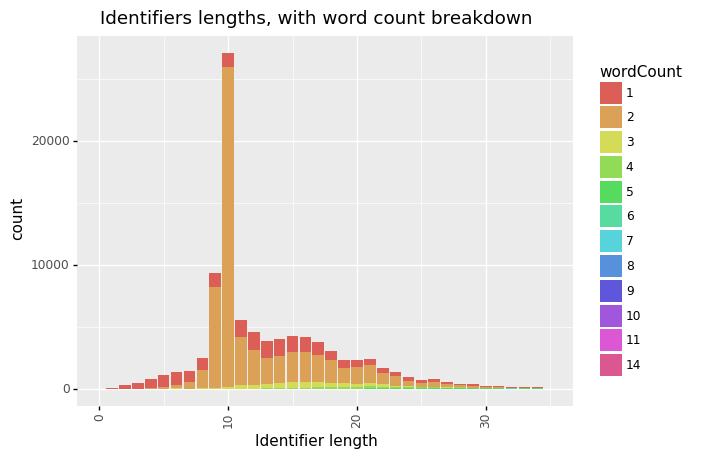

c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_count : Removed 416 rows containing non-finite values.
c:\users\t-niamit\pycharmprojects\pythonproject\venv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_bar : Removed 8 rows containing missing values.


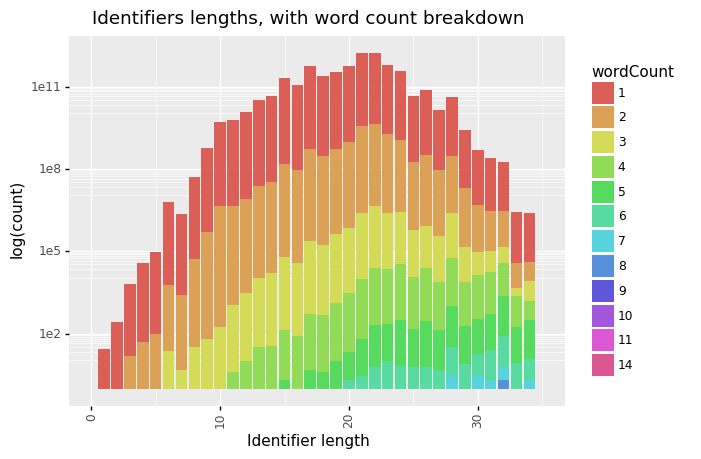

In [128]:
from plotnine import xlim

wordCount_length_freq = df.groupby(["name", "length"]).size()\
	.reset_index()\
	.sort_values("length", ascending=False)
wordCount_length_freq["wordCount"] = wordCount_length_freq["name"].apply(camel_case_split_and_count).astype('category')


print(
	ggplot(wordCount_length_freq)
	+ labs(x="Identifier length",
		   y="count",
		   title="Identifiers lengths, with word count breakdown")
	+ geom_bar(aes(x='length', fill="wordCount"))
  	+ xlim(0, 35)
	+ theme(axis_text_x=element_text(rotation=90))
)

print(
	ggplot(wordCount_length_freq)
	+ labs(x="Identifier length",
		   y="log(count)",
		   title="Identifiers lengths, with word count breakdown")
	+ geom_bar(aes(x='length', fill="wordCount"))
	+ scale_y_continuous(trans='log10')
  	+ xlim(0, 35)
	+ theme(axis_text_x=element_text(rotation=90))
)